In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from os.path import join
from glob import glob

In [3]:
#initialize dataframe
path="... spotify data path"
df = pd.concat([pd.read_json(f) for f in glob(join(path, "StreamingHistory*.json"))])
df = df[pd.to_datetime(df["endTime"]).dt.year <= 2022]

In [4]:
#clean up dataframe
df["date"] = pd.to_datetime(df.endTime).dt.date
df["minutes_played"] = df.msPlayed / 1000 / 60

top_artists = df.groupby(["artistName"]).agg({"minutes_played": "sum"}).reset_index().sort_values(
        ["minutes_played"], ascending=[False]) 

df = df.groupby(["artistName", "date"]).agg({"minutes_played": "sum"}).reset_index().sort_values(
        ["date", "minutes_played"], ascending=[True, False])

In [5]:
#shrink top_artists to just include top artists
print(list(top_artists["artistName"])[:5])
top_artists = top_artists[top_artists['artistName'].isin(list(top_artists["artistName"])[:5])]

['Cavetown', 'Snail Mail', 'Peach Pit', 'Soccer Mommy', 'Lizzy McAlpine']


In [6]:
#complete df
top_artists = top_artists.drop(columns=['minutes_played'])
df = df[df['artistName'].isin(list(top_artists["artistName"])[:5])]
df = df.drop(columns=['artistName','minutes_played']).merge(top_artists,how='cross').merge(df,how='left')
df["minutes_played"] = df.groupby('artistName')['minutes_played'].ffill().fillna(0)
df = df.drop_duplicates()

In [9]:
#create cumulative minutes for each date
df["date_cumulative"] = df.groupby(["date"])["minutes_played"].cumsum()
df = df.merge(df.groupby(["date"])['minutes_played'].sum(),on=['date'])
df = df.rename(columns={"minutes_played_y": "date_sum","minutes_played_x": "minutes_played"})


In [10]:
df['artist_proportion'] = df['date_cumulative'] / df['date_sum'] #normalize minutes

In [12]:
def plot_normalized_minutes(df, cutoff=1.5):
    df.sort_values(["artistName", "date"])
    df.index = pd.to_datetime(df["date"], infer_datetime_format=True)
    df = df.drop(columns=["date"])
    fig, ax = plt.subplots(figsize=(15, 7.5))
    for x in df["artistName"].drop_duplicates().to_list():
        ax.plot(df[df["artistName"].isin([x])]["artist_proportion"], label=x)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_ylabel('Minutes normalized by top artist minutes')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False, fancybox=True, shadow=True, 
              ncol=9, title='Artist')
    #plt.savefig('../output/2022_streaming_artists.png', bbox_inches='tight')
    plt.show()

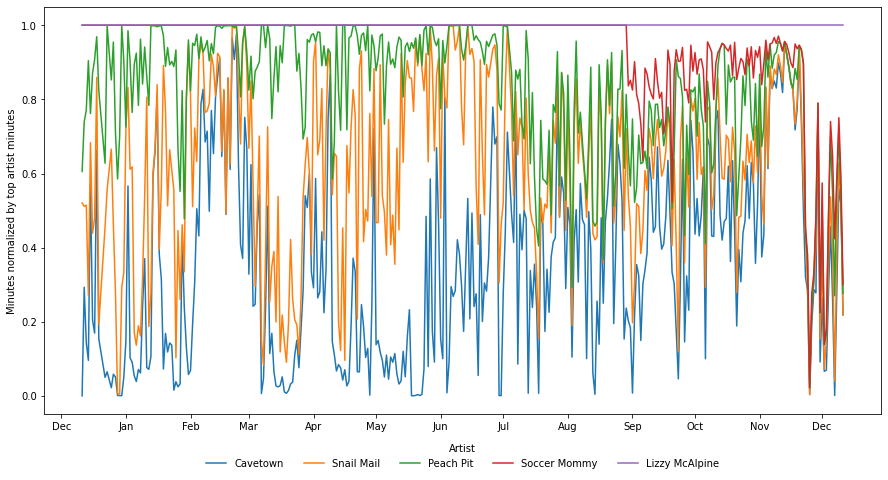

In [13]:
plot_normalized_minutes(df) display

In [26]:
#export data in csv to display in processing
import csv
header = ['date'] + list(top_artists['artistName'])[:5]

with open('spotify_wrapped2.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    counter = 0
    curr = []
    for row in list(zip(list(df['date']),list(df['artist_proportion']))):
        if counter <= 0:
            curr += [str(row[0])]
        curr += [row[1]]
        if counter >= 4:
            writer.writerow(curr)
            print(curr)
            curr = []
            counter = -1
        counter +=1

['2021-12-11', 0.0, 0.5206017217961534, 0.605473180523989, 1.0, 1.0]
['2021-12-12', 0.2931964769022633, 0.5114871010282166, 0.7393147938105851, 1.0, 1.0]
['2021-12-13', 0.14305535437312727, 0.5145672353483584, 0.7707410945806968, 1.0, 1.0]
['2021-12-14', 0.09589761058637342, 0.27085262080264566, 0.9044623682961587, 1.0, 1.0]
['2021-12-15', 0.5717709124630206, 0.6832045454381186, 0.761762029459192, 1.0, 1.0]
['2021-12-16', 0.20482442871835885, 0.4387835918702438, 0.8704769100885514, 1.0, 1.0]
['2021-12-17', 0.16939330129397223, 0.4793966145905237, 0.9079356294694989, 1.0, 1.0]
['2021-12-18', 0.6636082460123774, 0.859161216165615, 0.9690771354463429, 1.0, 1.0]
['2021-12-19', 0.1538673094803791, 0.19369559298016828, 0.8229660801629012, 1.0, 1.0]
['2021-12-22', 0.05005259467040673, 0.4557369200232934, 0.6277527619891243, 1.0, 1.0]
['2021-12-23', 0.06511409855175297, 0.556499106057403, 0.9985195430322826, 1.0, 1.0]
['2021-12-25', 0.02200347671202377, 0.6657779582587234, 0.8524364702313857, 